# Image Process and Machine Learning

Dataset in use: https://www.kaggle.com/datasets/cashutosh/gender-classification-dataset/data

In [1]:
import os
import cv2
import random
import pickle
import logging
import numpy as np
from tqdm import tqdm
from sklearn import metrics
from skimage import feature
from sklearn.svm import SVC 
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def metric_report(actual, predicted):
    acc = metrics.accuracy_score(actual, predicted)
    precision = metrics.precision_score(actual, predicted)
    recall = metrics.recall_score(actual, predicted)
    f1 = metrics.f1_score(actual, predicted)    
    return (acc, precision, recall, f1)

In [4]:
ext='jpg'

In [5]:
def image_reader(file_path, in_use, ext=ext):
    
    images = []
    
    files = os.listdir(file_path)
    random.shuffle(files)

    files = files[:int(len(files)*in_use)]
    
    for file in tqdm(files, desc = 'Reading Images'):
        if file.endswith(ext):
            img_path = os.path.join(file_path, file)
            img = cv2.imread(img_path, 0)
            images.append(img)
            
    return images

In [6]:
# male_dir = './dataset/Training/male'
# female_dir = './dataset/Training/female'

# male_test_dir = './dataset/Validation/male'
# female_test_dir = './dataset/Validation/female'

In [7]:
# train_male_images = image_reader(male_dir, 0.25)
# train_female_images = image_reader(female_dir, 0.25)

Reading Images: 100%|███████████████████████████████████████████████████| 5810/5810 [00:12<00:00, 465.45it/s]


In [8]:
# test_male_images = image_reader(male_test_dir, 0.1)
# test_female_images = image_reader(female_test_dir, 0.1)

Reading Images: 100%|█████████████████████████████████████████████████████| 584/584 [00:01<00:00, 328.43it/s]


## Histogram of Oriented Gradients

In [9]:
hog = cv2.HOGDescriptor()

In [10]:
def hog_pattern_extractor(desc: cv2.HOGDescriptor, images, gender, ext=ext, r_shape=(64, 128)):
    data = []
    labels = []
    
    for img in tqdm(images):
        img_resized = cv2.resize(img, r_shape)
        
        hist = hog.compute(img_resized)
        hist = hist.flatten()
        
        data.append(hist)
        labels.append(gender)
        
    return data, labels

In [11]:
def hog_detector(model, target_images, gender, ext=ext, r_shape=(64, 128)):
        
    actual, predicted = [], []
    for img in tqdm(target_images, desc='SVM Inference'):
        img_resized = cv2.resize(img, r_shape)
            
        hist = hog.compute(img_resized)
        hist = hist.flatten()
            
        pred = model.predict(hist.reshape(1, -1))[0]            
        actual.append(gender)
        predicted.append(pred)
            
    return actual, predicted

In [12]:
def hog_predict(model_instance, target, r_shape=(64, 128)):
    
    if os.path.isfile(target): logging.debug(f"{target} is a single image.")
        
    img_resized = cv2.resize(target, r_shape)
    hist = hog.compute(img_resized)
    hist = hist.flatten()
    
    pred = model_instance.predict(hist.reshape(1, -1))[0]
    return pred

In [13]:
# data_hog_male, labels_hog_male = hog_pattern_extractor(hog, train_male_images, 0)
# data_hog_female, labels_hog_female = hog_pattern_extractor(hog, train_female_images, 1)

100%|██████████████████████████████████████████████████████████████████| 5810/5810 [00:01<00:00, 4422.32it/s]


In [14]:
# data = np.vstack((data_hog_male, data_hog_female))
# labels = np.hstack((labels_hog_male, labels_hog_female))

In [15]:
# model_hog = SVC(kernel='linear', random_state=42)
# model_hog.fit(data, labels)

SVC(kernel='linear', random_state=42)

In [16]:
# actual_m, predicted_m = hog_detector(model_hog, test_male_images, 0)
# actual_f, predicted_f = hog_detector(model_hog, test_female_images, 1)

SVM Inference: 100%|██████████████████████████████████████████████████████| 584/584 [00:04<00:00, 142.42it/s]


In [17]:
# actual = np.hstack((actual_m, actual_f))
# predicted = np.hstack((predicted_m, predicted_f))

In [18]:
# metric_report(actual, predicted)

(0.9123711340206185,
 0.9126712328767124,
 0.9126712328767124,
 0.9126712328767124)

In [19]:
# confusion_matrix = metrics.confusion_matrix(actual, predicted)

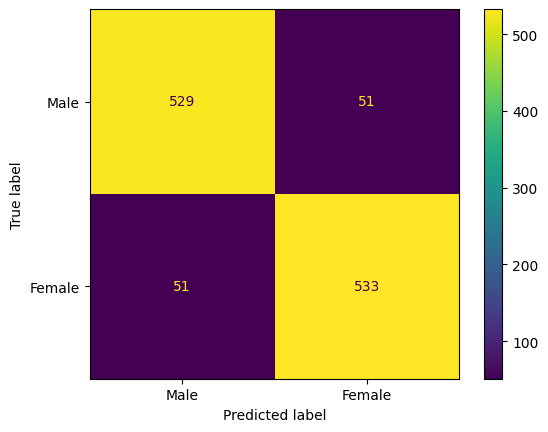

In [20]:
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Male', 'Female'])
# cm_display.plot()
# plt.show()

In [21]:
fname = 'hog_svm_model.sav'
# pickle.dump(model_hog, open(fname, 'wb'))

In [22]:
loaded_model = pickle.load(open(fname, 'rb'))

In [23]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve hog ile gender detect edilir.

img_path = './test_images/064943.jpg.jpg'
img = cv2.imread(img_path, 0)
actual = int(os.path.basename(img_path).startswith('1'))

pred = hog_predict(loaded_model, img)

if actual == pred:
    print('Gender Detected!')

Gender Detected!


## Local Binary Patterns

In [24]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius

    def describe(self, image, eps=1e-7):
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(),
                                 bins=np.arange(0, self.numPoints + 3),
                                 range=(0, self.numPoints + 2))
        
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        return hist

In [25]:
def lbp_detector(model, target_images, gender, ext=ext):
        
    actual, predicted = [], []
    for img in tqdm(target_images, desc='SVM Inference'):
        hist = desc.describe(img)
            
        pred = model.predict(hist.reshape(1, -1))[0]            
        actual.append(gender)
        predicted.append(pred)
            
    return actual, predicted

In [26]:
def lbp_predict(model_instance, target):
        
    hist = desc.describe(target)
    hist = hist.flatten()
    
    pred = model_instance.predict(hist.reshape(1, -1))[0]
    return pred

In [27]:
desc = LocalBinaryPatterns(20, 5)

In [28]:
# male_histograms = np.load('male_lbp_histograms.npy')
# female_histograms = np.load('female_lbp_histograms.npy')

In [29]:
# data = np.vstack((male_histograms, female_histograms))
# labels = np.hstack( (np.zeros(len(male_histograms)), np.ones(len(female_histograms))) )

In [30]:
# model_lbp = SVC(kernel='linear', random_state=42)
# model_lbp.fit(data, labels)

SVC(kernel='linear', random_state=42)

In [31]:
# actual_m, predicted_m = lbp_detector(model_lbp, test_male_images, 0)
# actual_f, predicted_f = lbp_detector(model_lbp, test_female_images, 1)

SVM Inference: 100%|██████████████████████████████████████████████████████| 584/584 [00:03<00:00, 171.71it/s]


In [32]:
# actual = np.hstack((actual_m, actual_f))
# predicted = np.hstack((predicted_m, predicted_f))

In [33]:
# metric_report(actual, predicted)

(0.6821305841924399,
 0.7026515151515151,
 0.6352739726027398,
 0.6672661870503597)

In [34]:
# confusion_matrix = metrics.confusion_matrix(actual, predicted)

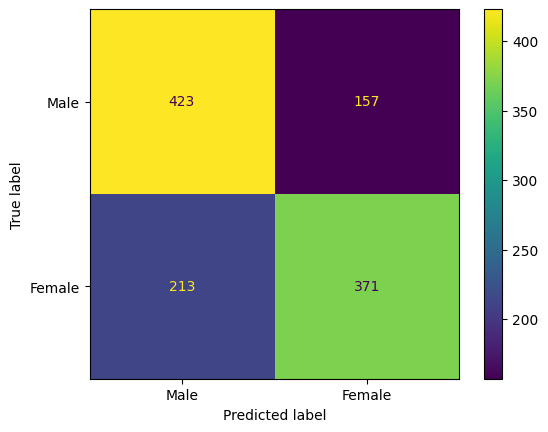

In [35]:
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Male', 'Female'])
# cm_display.plot()
# plt.show()

In [36]:
fname = 'lbp_svm_model.sav'
pickle.dump(model_lbp, open(fname, 'wb'))

In [37]:
loaded_model = pickle.load(open(fname, 'rb'))

In [38]:
# Asagidaki img_path degiskenine istenen goruntulerin pathi verilir ve lbp ile gender detect edilir.

img_path = './test_images/064943.jpg.jpg'
img = cv2.imread(img_path, 0)
actual = int(os.path.basename(img_path).startswith('1'))

pred = lbp_predict(loaded_model, img)

if actual == pred:
    print('Gender Detected!')

Gender Detected!


## Scale Invariant Feature Transform

In [39]:
sift = cv2.SIFT_create()

In [40]:
def descriptor_extractor(image):    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return keypoints, descriptors

In [41]:
def preprocessing(img, r_shape):
    img = cv2.resize(img, r_shape, interpolation=cv2.INTER_AREA)
    return img

In [42]:
def sift_pattern_extractor(desc: cv2.HOGDescriptor, images, gender, num_descriptors=20, ext=ext, r_shape=(128, 128)):
    data = []
    labels = []
    
    for img in tqdm(images):
        img_resized = preprocessing(img, r_shape)
        
        keypoints, descriptors = descriptor_extractor(img_resized) 
        
        if(len(descriptors) < num_descriptors):
            continue
        
        random_indices = random.sample(range(len(descriptors)), num_descriptors)
        random_descriptors = [descriptors[i] for i in random_indices]
    
        data.append(random_descriptors)
        labels.append(gender)
        
    return data, labels

In [43]:
def sift_detector(model, target_images, gender, ext=ext, r_shape=(128, 128)):
    actual, predicted = [], []
    for img in tqdm(target_images, desc='SVM Inference'):
        img_resized = cv2.resize(img, r_shape)
            
        hist = hog.compute(img_resized)
        hist = hist.flatten()
            
        pred = model.predict(hist.reshape(1, -1))[0]            
        actual.append(gender)
        predicted.append(pred)
            
    return actual, predicted

In [44]:
#data_sift_male, labels_sift_male = sift_pattern_extractor(sift, train_male_images, 0)
#data_sift_female, labels_sift_female = sift_pattern_extractor(sift, train_female_images, 1)

In [45]:
#data = np.vstack((data_sift_male, data_sift_female))
#labels = np.hstack((labels_sift_male, labels_sift_female))

In [46]:
## Bag of Words will be implemented (feedback)